In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_palette("Set2")

## 1. データの取得

- `https://www.kaggle.com/nikdavis/steam-store-games`から取得
- 一部のカラム（ex.platforms）は「;」区切りで複数の値が入っているので、前もってスプリットしたデータを扱うことにする

In [2]:
df = pd.read_csv("steam_parsed.tsv", delimiter="\t")
df.head()

,appid,name,release_date,english,developer,publisher,platform1,platform2,platform3,required_age,...,steamspy_tags1,steamspy_tags2,steamspy_tags3,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000/11/1,1,Valve,Valve,windows,mac,linux,0,...,Action,FPS,Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999/4/1,1,Valve,Valve,windows,mac,linux,0,...,Action,FPS,Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003/5/1,1,Valve,Valve,windows,mac,linux,0,...,FPS,World War II,Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001/6/1,1,Valve,Valve,windows,mac,linux,0,...,Action,FPS,Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999/11/1,1,Gearbox Software,Valve,windows,mac,linux,0,...,FPS,Action,Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


## 2. プラットフォーム分布

カラムスプリットの結果、プラットフォームのカラムが３つもできたので、それぞれ抽出してunionする関数を作成

In [3]:
def union_data(df, base_cols, prefix, suffix_num):
    return_cols = base_cols.copy()
    return_cols.append(prefix)
    result = pd.DataFrame(columns=return_cols)
    
    for i in range(suffix_num):
        needed_cols = base_cols.copy()
        added_col = prefix + str(i + 1)
        needed_cols.append(added_col)
        temp = df.loc[~df[added_col].isnull(), needed_cols]
        temp = temp.rename(columns={added_col: prefix})
        result = result.append(temp, ignore_index=True, sort=False)
    
    return result

以下のようなアウトプットを作る

In [4]:
platform = union_data(df, ["appid", "name"], "platform", 3).sort_values(by=["appid", "platform"]).reset_index(drop=True)
platform.head()

,appid,name,platform
0,10,Counter-Strike,linux
1,10,Counter-Strike,mac
2,10,Counter-Strike,windows
3,20,Team Fortress Classic,linux
4,20,Team Fortress Classic,mac


- SteamはPCゲーム向けのプラットフォームなので、ほとんどのゲームがwindows専用

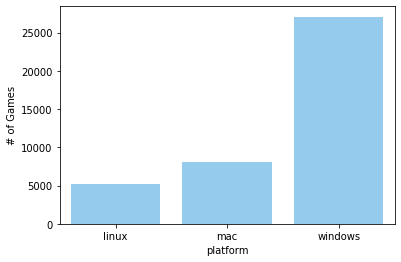

In [5]:
ax = sns.barplot(x="platform", y="appid", data=platform, estimator=lambda x: len(np.unique(x)), ci=None, color="lightskyblue")
ax.set(ylabel="# of Games")
plt.show()

## 3.価格分布

- 約8割のゲームが10ポンド（約1400円）未満なので、ゲーム本体は手頃な値段設定になっている
- ただし、SteamではDLC販売が主流なので、DLCのデータを紐づけない限り、コンテンツ全体の値段を把握することはできない

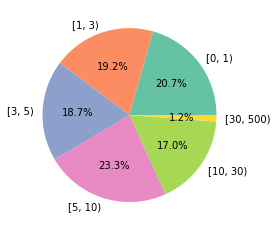

In [6]:
price_count = pd.cut(df["price"], [0, 1, 3, 5, 10, 30, 500], right=False).value_counts().sort_index()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.pie(price_count.values, labels=price_count.index, autopct="%1.1f%%")
plt.show()

## 4. ジャンル分布

- インディーゲームが盛り上がっていることが分かる（ジャンルと呼べるのかは別として）
- ゲームの発売数は、アクション > カジュアル >= アドベンチャーの順

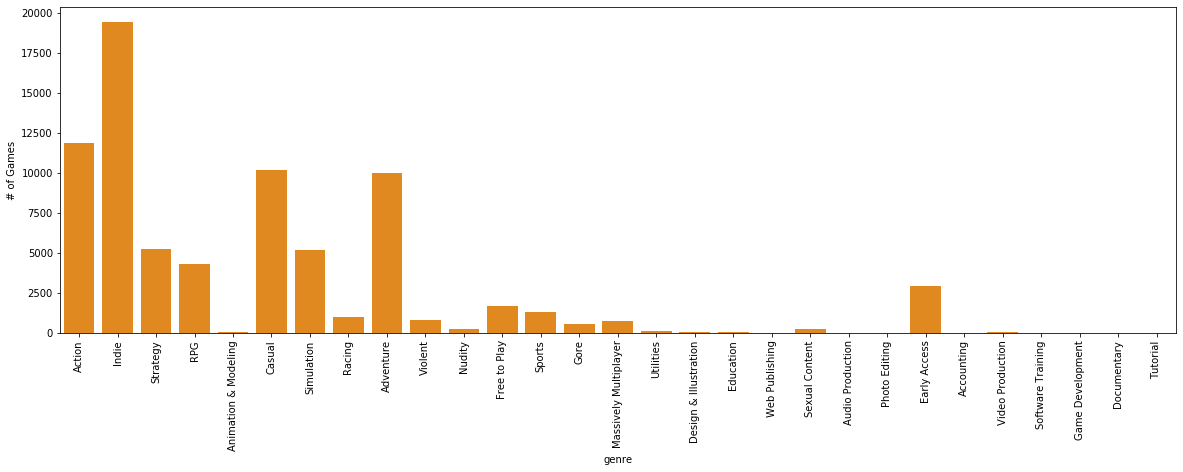

In [7]:
genres = union_data(df, ["appid", "name", "price"], "genre", 10)

plt.figure(figsize=(20, 6))
ax = sns.barplot(x="genre", y="appid", data=genres, estimator=lambda x: len(np.unique(x)), ci=None, color="darkorange")
ax.set(ylabel="# of Games")
plt.xticks(rotation=90)
plt.show()

- メインジャンルの中では、シミュレーションゲームの平均価格が一番高い
- カジュアルゲームの平均価格は、インディーゲームの平均価格よりも低い

In [9]:
main_genres = genres.query('genre in ["Action", "Indie", "Strategy", "RPG", "Casual", "Simulation", "Adventure"]')
main_genres[["genre", "price"]].groupby("genre").mean().sort_values("price", ascending=False).round(2)

,price
genre,
Simulation,7.21
Strategy,6.94
RPG,6.94
Action,6.14
Adventure,6.12
Indie,5.05
Casual,4.11


## 5. 発売年度

- 2014年以降、発売数が目に見えるほど増えている
- データが2019年5月ごろ取得されたので、2019年の数値は参考程度に

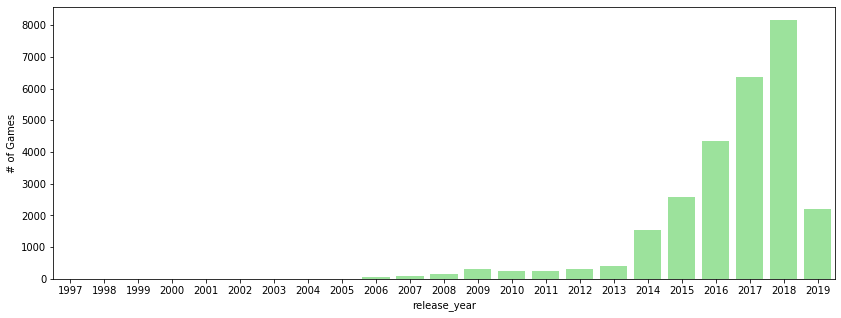

In [10]:
df["release_date"] = pd.to_datetime(df["release_date"])
release = union_data(df, ["appid", "name", "release_date"], "genre", 10)
release["release_year"] = release["release_date"].apply(lambda x: x.year)

plt.figure(figsize=(14, 5))
ax = sns.barplot(x="release_year", y="appid", data=release, estimator=lambda x: len(np.unique(x)), ci=None, color="lightgreen")
ax.set(ylabel="# of Games")
plt.show()

- 発売数が一気に増えた2014年時点で、既にインディーゲームの数がトップとなっている

In [11]:
release_pivot = release.query('genre in ["Action", "Indie", "Strategy", "RPG", "Casual", "Simulation", "Adventure"]')
release_pivot = pd.pivot_table(release_pivot.loc[release_pivot["release_year"].between(2014, 2018), ["appid", "genre", "release_year"]],
                               index="release_year", columns="genre", values="appid", aggfunc=len)
release_pivot

genre,Action,Adventure,Casual,Indie,RPG,Simulation,Strategy
release_year,,,,,,,
2014,647,582,404,887,283,240,331
2015,1156,1011,754,1900,502,467,578
2016,1950,1636,1624,3154,621,849,806
2017,2905,2478,2560,4706,935,1231,1174
2018,3513,3001,3624,6404,1276,1717,1457


- 成長率は全体的に鈍化している
- 特にアクションとアドベンチャーゲームは、その傾向が強い

In [12]:
for col in release_pivot.columns:
    col_name = "_".join([col, "Growth(%)"])
    release_pivot[col_name] = round(release_pivot[col].pct_change() * 100, 1)
release_pivot.drop(["Action", "Indie", "Strategy", "RPG", "Casual", "Simulation", "Adventure"], axis=1)

genre,Action_Growth(%),Adventure_Growth(%),Casual_Growth(%),Indie_Growth(%),RPG_Growth(%),Simulation_Growth(%),Strategy_Growth(%)
release_year,,,,,,,
2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,78.7,73.7,86.6,114.2,77.4,94.6,74.6
2016,68.7,61.8,115.4,66.0,23.7,81.8,39.4
2017,49.0,51.5,57.6,49.2,50.6,45.0,45.7
2018,20.9,21.1,41.6,36.1,36.5,39.5,24.1


## 6.ユーザー評価分布

In [13]:
ratings = df.loc[:, ["appid", "name", "developer", "positive_ratings", "negative_ratings"]]
ratings["total_ratings"] = ratings["positive_ratings"] + ratings["negative_ratings"]
ratings["positive_rates"] = ratings.apply(lambda x: x[3] / (x[5]) * 100, axis=1)
ratings["positive_rates_bin"] = pd.cut(ratings["positive_rates"], [0, 50, 70, 80, 95, 100], right=False)
ratings.head()

,appid,name,developer,positive_ratings,negative_ratings,total_ratings,positive_rates,positive_rates_bin
0,10,Counter-Strike,Valve,124534,3339,127873,97.388815,"[95, 100)"
1,20,Team Fortress Classic,Valve,3318,633,3951,83.978740,"[80, 95)"
2,30,Day of Defeat,Valve,3416,398,3814,89.564761,"[80, 95)"
3,40,Deathmatch Classic,Valve,1273,267,1540,82.662338,"[80, 95)"
4,50,Half-Life: Opposing Force,Gearbox Software,5250,288,5538,94.799567,"[80, 95)"


- 95%以上の圧倒的好評を受けているゲームはわずか4.6%
- 不評が多い17.5%のゲームを除けば、多くのゲームは好評が多い

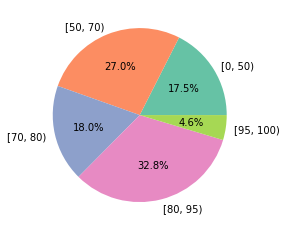

In [14]:
ratings_count = ratings["positive_rates_bin"].value_counts().sort_index()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.pie(ratings_count.values, labels=ratings_count.index, autopct="%1.1f%%")
plt.show()

- あまりにもつまらないゲームは、そもそも評価もしないと可能性があるので、1000件以上に絞ってみる
- 不評が多いタイトルの割合が急減し、かわりに80%以上の好評を受けているタイトルの割合が増加

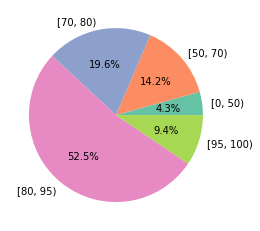

In [15]:
ratings_count2 = ratings.loc[ratings["total_ratings"] >= 1000, "positive_rates_bin"].value_counts().sort_index()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.pie(ratings_count2.values, labels=ratings_count2.index, autopct="%1.1f%%")
plt.show()

## 7.デベロッパー

- 発売タイトル数が多い順で、Top 10のデベロッパーを描画
- アトリエ、信長の野望、三国志シリーズの影響もあり、Koei Tecmo Gamesが２位にランク

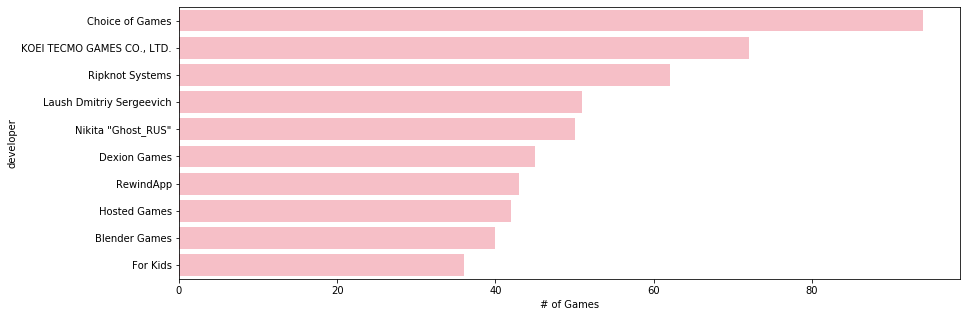

In [16]:
developers = ratings.groupby("developer").agg(count=("developer", "size"), avg_positive_rates=("positive_rates", "mean"))
developers = developers.reset_index().sort_values(by="count", ascending=False).reset_index(drop=True)

plt.figure(figsize=(14, 5))
ax = sns.barplot(y="developer", x="count", data=developers[:10], ci=None, color="lightpink", orient="h")
ax.set(xlabel="# of Games")
plt.show()

- 上位デベロッパーの中では、Dexion Gamesの低い評価が目立つ

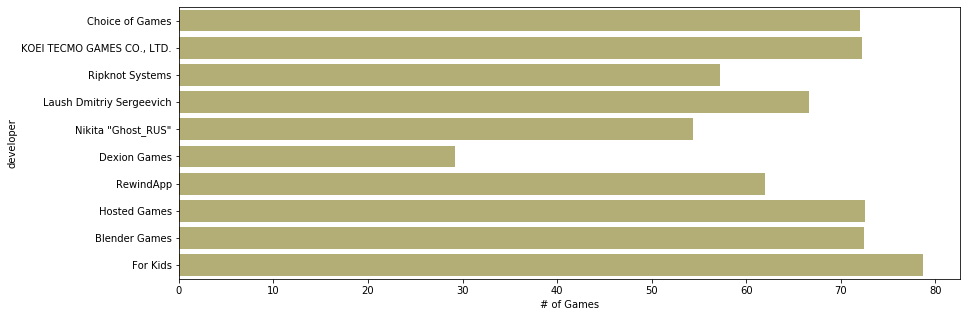

In [17]:
plt.figure(figsize=(14, 5))
ax = sns.barplot(y="developer", x="avg_positive_rates", data=developers[:10], ci=None, color="darkkhaki", orient="h")
ax.set(xlabel="# of Games")
plt.show()